In [ ]:
import pandas as pd
import os
import sys
import numpy as np


os.chdir('S:/Fall')

In [ ]:
# Miles.csv is a supporting file generated to capture the average route distance travelled in miles by 
# flights (typically Sun country fleet - Boeing 737-700)
# Sourced from "https://www.airmilescalculator.com/"


df_miles = pd.read_csv('S:/Fall/miles.csv', encoding='unicode_escape', usecols = [0,1,2])
df_miles.head()

,origin,dest,miles
0,JFK,MSP,1028
1,MSP,JFK,1028
2,MSP,SFO,1589
3,SFO,MSP,1589
4,MCO,MSP,1310


In [ ]:
df_miles['Route'] = df_miles['origin'].astype(str)+"-"+df_miles['dest'].astype(str)
df_miles = df_miles[['Route', 'miles']]
# df_miles.index = df_miles['Route']
df_miles = df_miles.set_index('Route')

In [ ]:
df_miles.head()

,miles
Route,
JFK-MSP,1028
MSP-JFK,1028
MSP-SFO,1589
SFO-MSP,1589
MCO-MSP,1310


In [ ]:
df = pd.read_csv('S:\Fall\xyz_airline.csv')
df.columns

C:\Users\ranga\AppData\Local\Temp\ipykernel_16092\1624893941.py:1: DtypeWarning: Columns (12,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('S:\Fall\SunCountry.csv')


Index(['PNRLocatorID', 'TicketNum', 'CouponSeqNbr', 'ServiceStartCity',
       'ServiceEndCity', 'PNRCreateDate', 'ServiceStartDate', 'PaxName',
       'EncryptedName', 'GenderCode', 'birthdateid', 'Age', 'PostalCode',
       'BkdClassOfService', 'TrvldClassOfService', 'BookingChannel',
       'BaseFareAmt', 'TotalDocAmt', 'UFlyRewardsNumber', 'UflyMemberStatus',
       'CardHolder', 'BookedProduct', 'EnrollDate', 'MarketingFlightNbr',
       'MarketingAirlineCode', 'StopoverCode'],
      dtype='object')

# Data Transformation 

### Aggregating the data at Route level

In [ ]:
# Creating Route column and adding to 3 dataframes

df['PNRCreateDate'] = pd.to_datetime(df['PNRCreateDate'])
df['ServiceStartDate'] = pd.to_datetime(df['ServiceStartDate'])
df['Route'] = df['ServiceStartCity'] + "-"+df['ServiceEndCity']

# Booking to Travel time 
df['BookTravelDays'] = (df['ServiceStartDate'] - df['PNRCreateDate']) / np.timedelta64(1, 'D')


In [ ]:
df['BYear'] = df.PNRCreateDate.dt.year
df['BMonth'] = df.PNRCreateDate.dt.month

df['TYear'] = df.ServiceStartDate.dt.year
df['TMonth'] = df.ServiceStartDate.dt.month

In [ ]:
def quarter(val):    
    q = 1
    if val < 4:
        q = 1
    elif 4 <= val < 7:
        q = 2
    elif 7 <= val < 10:
        q = 3
    else:
        q = 4
    
    return q 

In [ ]:
# Columms to capture the Flight Bookings in each Quarter of fiscal year
# BQ1 - # of tickets booked in Quarter 1
# TQ1 - # of tickets travelled in Quarter 1

df['BQuarter'] = df['BMonth'].apply(lambda row : quarter(row))
df['TQuarter'] = df['TMonth'].apply(lambda row : quarter(row))

df['BQ1'] = df['BQuarter'].apply(lambda x: 1 if x == 1 else 0)
df['BQ2'] = df['BQuarter'].apply(lambda x: 1 if x == 2 else 0)
df['BQ3'] = df['BQuarter'].apply(lambda x: 1 if x == 3 else 0)
df['BQ4'] = df['BQuarter'].apply(lambda x: 1 if x == 4 else 0)
df['TQ1'] = df['TQuarter'].apply(lambda x: 1 if x == 1 else 0)
df['TQ2'] = df['TQuarter'].apply(lambda x: 1 if x == 2 else 0)
df['TQ3'] = df['TQuarter'].apply(lambda x: 1 if x == 3 else 0)
df['TQ4'] = df['TQuarter'].apply(lambda x: 1 if x == 4 else 0)


In [ ]:
df_Route_P1 = df.groupby('Route').agg({'TicketNum':'count', 'BookTravelDays':'mean', \
                               'BQ1' : 'sum', 'BQ2' : 'sum', 'BQ3' : 'sum', 'BQ4' : 'sum', \
                              'TQ1' : 'sum', 'TQ2' : 'sum', 'TQ3' : 'sum', 'TQ4' : 'sum',
                              }).rename(columns = {'TicketNum' : 'BookingCount'})

df_Route_P1.head()

,BookingCount,BookTravelDays,BQ1,BQ2,BQ3,BQ4,TQ1,TQ2,TQ3,TQ4
Route,,,,,,,,,,
ANC-DEN,17,137.294118,12,5,0,0,0,4,13,0
ANC-MSP,21270,97.452515,6251,10778,2793,1448,0,4008,17262,0
AZA-DEN,23,46.043478,19,0,0,4,15,8,0,0
BOS-MSP,108695,50.844731,19231,34594,32715,22155,11487,28568,38585,30055
CUN-DEN,7,99.142857,3,0,0,4,6,1,0,0
...,...,...,...,...,...,...,...,...,...,...
TPA-DEN,24,50.791667,21,2,0,1,4,20,0,0
TPA-MSP,17562,83.383498,6439,610,2355,8158,12421,2440,0,2701
TYS-DEN,1,23.000000,0,1,0,0,0,1,0,0


In [ ]:
df['Passenger'] = df['PaxName'] + df['birthdateid'].map(str)

In [ ]:
#Age..Avg imputation - [YA,M,E] and Avg
df['Age'] = df['Age'].fillna(df['Age'].mean())

df['Age_YA'] = df['Age'].apply(lambda x: 1 if (x>0 and x<=18) else 0)
df['Age_M'] = df['Age'].apply(lambda x: 1 if (x>18 and x<=55) else 0)
df['Age_E'] = df['Age'].apply(lambda x: 1 if (x>55 and x<=100) else 0)

In [ ]:
# Gender Class

df['Gender'] = df['GenderCode'].map({"F":1,"M":0})


In [ ]:
##Travel Class - [C,FC & Upgrades] - Considering the Discount First Class as First class 
df['TrvldClass_FC'] = df['TrvldClassOfService'].apply(lambda x: 1 if x in ['First Class','Discount First Class'] else 0)
df['TrvldClass_C'] = df['TrvldClassOfService'].apply(lambda x: 1 if x == 'Coach' else 0)
df['Upgrade'] = df['BkdClassOfService'] ==  df['TrvldClassOfService']
df['Upgrade'] = df['Upgrade'].apply(lambda x:0 if x==True else 1)

#Booking Channel Count - [SCA, Other]
df['Channel'] = df['BookingChannel'].apply(lambda x: 1 if 'SCA' in x else 0)

In [ ]:
df_Route_P2 = df.groupby('Route').agg({'Passenger':'nunique','Age_YA':'sum','Age_M':'sum','Age_E':'sum', \
                                       'Age':'mean', 'Gender':'sum','TrvldClass_FC':'sum','TrvldClass_C':'sum', \
                                       'Upgrade':'sum','Channel':'sum' }).rename(columns = {'Passenger' : 'UniquePassengers', \
                                'TrvldClass_FC' : 'FirstClass', 'TrvldClass_C' : 'Coach', 'Channel' : 'SCA_ChannelCount', \
                                                                           'Age' : 'Mean_Age'})
df_Route_P2.head()


,UniquePassengers,Age_YA,Age_M,Age_E,Mean_Age,Gender,FirstClass,Coach,Upgrade,SCA_ChannelCount
Route,,,,,,,,,,
ANC-DEN,17,0,9,8,51.470588,5.0,0,17,0,0
ANC-MSP,18738,3047,10757,7410,44.272613,9262.0,1822,19448,1308,9322
AZA-DEN,23,9,11,3,29.869565,10.0,0,23,0,0
BOS-MSP,87164,12518,73490,22156,38.716025,54829.0,7113,101582,5190,47761
CUN-DEN,7,0,5,2,37.857143,3.0,0,7,0,0


In [ ]:
# # Filter only SY flights
# df = df.loc[df['MarketingAirlineCode'] == 'SY']

# Base fare sum
df['TotalBaseFare'] = df.groupby('Route')['BaseFareAmt'].transform('sum')

df['suppFare'] = df['TotalDocAmt'] - df['BaseFareAmt']
df['suppFare'] = df['suppFare'].apply(lambda x : x if x > 0 else 0)

# Supplimentary fare sum
df['TotalSuppFare'] = df.groupby('Route')['suppFare'].transform('sum')

In [ ]:
# Counting u fly Elite & Standard customers
df['UFly_Elite'] = (df.assign(elite = df['UflyMemberStatus'].where(df['UflyMemberStatus'] == 'Elite'))
                          .groupby('Route')['elite']
                          .transform('count'))
df['UFly_Standard'] = (df.assign(elite = df['UflyMemberStatus'].where(df['UflyMemberStatus'] == 'Standard'))
                          .groupby('Route')['elite']
                          .transform('count'))

In [ ]:
#Promo count
df['PromoCount'] = (df.assign(disc = df['BookedProduct'].where(~df['BookedProduct'].isnull()))
                          .groupby('Route')['disc']
                          .transform('count'))

In [ ]:
# Trip Count - Number of flights trips 
df['Trips'] = df['ServiceStartDate'].astype(str) + '-'+ df['MarketingFlightNbr'].astype(str)
df['TripCount'] = df.groupby(['Route', 'Trips'])['Trips'].transform('count')


#Taking into new df
df_Route_P3 = df.groupby('Route')[['TotalBaseFare', 'TotalSuppFare', 'UFly_Elite', 'UFly_Standard', 'PromoCount', 'TripCount']].first()
df_Route_P3.head()

,TotalBaseFare,TotalSuppFare,UFly_Elite,UFly_Standard,PromoCount,TripCount
Route,,,,,,
ANC-DEN,9944.24,982.38,0,0,0,2
ANC-MSP,11707360.29,1112137.41,10,3592,6767,112
AZA-DEN,6872.57,1261.83,0,0,0,1
BOS-MSP,31836711.61,4660598.89,606,21812,30668,150
CUN-DEN,4382.00,824.80,0,0,0,1


In [ ]:
df_Route = df_Route_P1.join(df_Route_P2)
df_Route = df_Route.join(df_Route_P3)
df_Route = (df_Route.join(df_miles)).reset_index()
df_Route.head()

,Route,BookingCount,BookTravelDays,BQ1,BQ2,BQ3,BQ4,TQ1,TQ2,TQ3,...,Coach,Upgrade,SCA_ChannelCount,TotalBaseFare,TotalSuppFare,UFly_Elite,UFly_Standard,PromoCount,TripCount,miles
0,ANC-DEN,17,137.294118,12,5,0,0,0,4,13,...,17,0,0,9944.24,982.38,0,0,0,2,2405
1,ANC-MSP,21270,97.452515,6251,10778,2793,1448,0,4008,17262,...,19448,1308,9322,11707360.29,1112137.41,10,3592,6767,112,2518
2,AZA-DEN,23,46.043478,19,0,0,4,15,8,0,...,23,0,0,6872.57,1261.83,0,0,0,1,596
3,BOS-MSP,108695,50.844731,19231,34594,32715,22155,11487,28568,38585,...,101582,5190,47761,31836711.61,4660598.89,606,21812,30668,150,1124
4,CUN-DEN,7,99.142857,3,0,0,4,6,1,0,...,7,0,0,4382.00,824.80,0,0,0,1,1669


In [ ]:
df_Route.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Route             241 non-null    object 
 1   BookingCount      241 non-null    int64  
 2   BookTravelDays    241 non-null    float64
 3   BQ1               241 non-null    int64  
 4   BQ2               241 non-null    int64  
 5   BQ3               241 non-null    int64  
 6   BQ4               241 non-null    int64  
 7   TQ1               241 non-null    int64  
 8   TQ2               241 non-null    int64  
 9   TQ3               241 non-null    int64  
 10  TQ4               241 non-null    int64  
 11  UniquePassengers  241 non-null    int64  
 12  Age_YA            241 non-null    int64  
 13  Age_M             241 non-null    int64  
 14  Age_E             241 non-null    int64  
 15  Mean_Age          241 non-null    float64
 16  Gender            241 non-null    float64
 1

In [ ]:
# df_Route_Final.reset_index().to_csv("S:/RouteDate.csv", index = False)

# Clustering Anlysis on Route profiles (241 Unique routes)

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_new = df_Route.iloc[:, 1:]

df_norm = StandardScaler().fit(df_new).transform(df_new)
pca = PCA().fit(df_norm)

# Exercise: To show the amount of varialce does each principal component explain
pca.explained_variance_ratio_

array([7.98547354e-01, 5.60643102e-02, 4.14880650e-02, 3.01966753e-02,
       2.23007266e-02, 2.05093478e-02, 1.35606961e-02, 8.53318407e-03,
       3.78091698e-03, 1.86759305e-03, 9.63365767e-04, 8.23501115e-04,
       3.96934712e-04, 3.26294796e-04, 2.05694823e-04, 1.48049500e-04,
       9.58987942e-05, 8.17912211e-05, 6.07408098e-05, 1.92891339e-05,
       1.50181000e-05, 1.21312969e-05, 2.41441558e-06, 6.05634511e-09,
       7.58684295e-33, 7.58684295e-33, 1.26093232e-33])

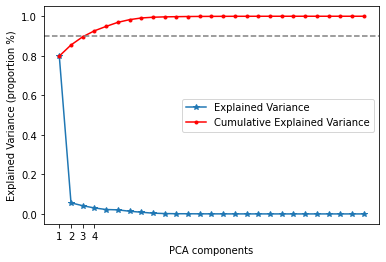

In [ ]:
exp_var = pca.explained_variance_ratio_ 
# cumulative sum of variance explained
exp_var_cumsum = np.cumsum(exp_var)


plt.plot(range(1, len(exp_var)+1),
        exp_var,'*-',label='Explained Variance')

plt.plot(range(1, len(exp_var)+1),
        exp_var_cumsum,'r.-',label='Cumulative Explained Variance')



plt.legend()
ax = plt.gca()
ax.set_xticks([1,2,3,4])
ax.set_xlabel('PCA components')
ax.set_ylabel('Explained Variance (proportion %)')

# which shows that the first two PCs accounts for more than 90% of the variance of the data.
plt.axhline(0.9,linestyle='--',color='grey')

In [ ]:
pca = PCA(n_components=3).fit(df_norm)
df_pca = pca.transform(df_norm)

In [ ]:
df_pca

array([[-2.04118972e+00,  1.73469164e+00,  7.55442763e-01],
       [ 1.15535769e+00,  1.06820564e+00,  1.11804511e+00],
       [-2.01678346e+00,  1.07435143e-01, -1.50360958e+00],
       [ 1.29402400e+01, -7.12465330e-01, -9.86628511e-01],
       [-2.02509827e+00,  1.27312079e+00, -3.54262207e-01],
       [ 4.62083157e+00, -2.38392072e-01, -6.93618952e-02],
       [-1.78739469e+00,  1.43378661e+00,  1.88840914e-01],
       [ 7.21269584e+00,  1.41323553e+00,  1.21593880e+00],
       [-9.51632541e-01,  9.11587952e-02,  7.46287093e-01],
       [-8.32365804e-01,  2.22130354e-01,  1.24725230e+00],
       [-2.04954106e+00, -1.39944760e-01, -7.00155726e-01],
       [ 2.33957522e+00, -7.61370509e-01, -1.04840617e+00],
       [-2.01638606e+00,  3.36988706e-01, -1.57078706e+00],
       [ 5.72150558e+00, -4.61213448e-01, -1.02895440e+00],
       [-2.06847394e+00, -5.56819872e-01,  6.22170161e-02],
       [-2.00903409e+00,  2.81839991e-01, -1.45074116e+00],
       [-2.00390784e+00,  1.44629431e+00

## 1. K-Means

In [ ]:
# Running K means clustering
distortions = []

K = range(1, 10)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_pca)
  
    distortions.append(kmeanModel.inertia_)

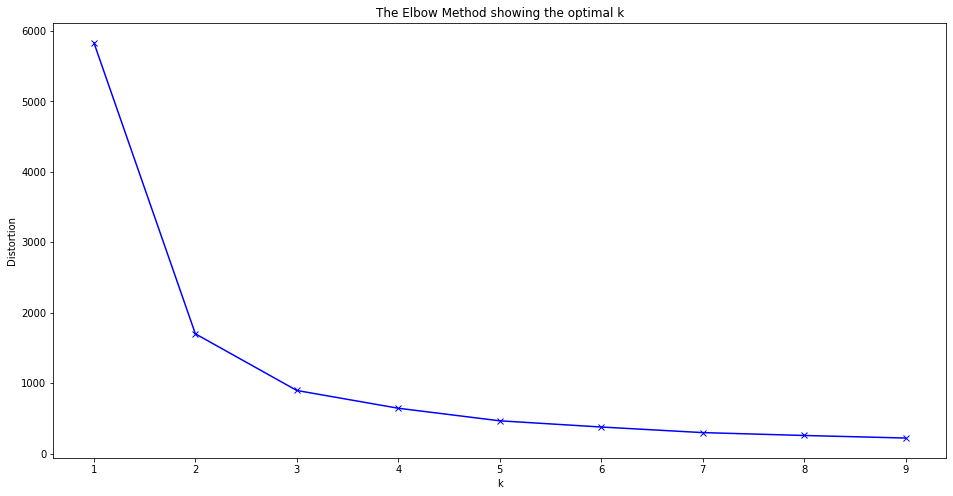

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=2)
preds = kmeans.fit_predict(df_pca)

In [ ]:
df_Route['cluster'] = preds
df_Route['cluster'].value_counts()

1    215
0     26
Name: cluster, dtype: int64

In [ ]:
df_Route_km = df_Route.copy()

In [ ]:
df_Route.iloc[:, 2:-1]

,BookTravelDays,BQ1,BQ2,BQ3,BQ4,TQ1,TQ2,TQ3,TQ4,UniquePassengers,...,Coach,Upgrade,SCA_ChannelCount,TotalBaseFare,TotalSuppFare,UFly_Elite,UFly_Standard,PromoCount,TripCount,miles
0,137.294118,12,5,0,0,0,4,13,0,17,...,17,0,0,9944.24,982.38,0,0,0,2,2405
1,97.452515,6251,10778,2793,1448,0,4008,17262,0,18738,...,19448,1308,9322,11707360.29,1112137.41,10,3592,6767,112,2518
2,46.043478,19,0,0,4,15,8,0,0,23,...,23,0,0,6872.57,1261.83,0,0,0,1,596
3,50.844731,19231,34594,32715,22155,11487,28568,38585,30055,87164,...,101582,5190,47761,31836711.61,4660598.89,606,21812,30668,150,1124
4,99.142857,3,0,0,4,6,1,0,0,7,...,7,0,0,4382.00,824.80,0,0,0,1,1669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,50.791667,21,2,0,1,4,20,0,0,24,...,24,0,0,7269.78,1329.72,0,0,0,7,1506
237,83.383498,6439,610,2355,8158,12421,2440,0,2701,16218,...,16227,1010,9217,4890182.31,709248.71,17,3447,3497,166,1306
238,23.000000,0,1,0,0,0,1,0,0,1,...,1,0,0,368.37,60.33,0,0,0,1,1162
239,0.000000,0,0,1,0,0,0,1,0,1,...,1,0,0,0.00,0.00,0,0,1,1,847


## 2. DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import numpy as np
#from adspy_shared_utilities import plot_labelled_scatter


df_new = df_Route.iloc[:, 2:-1]
df_new.head()

df_norm = MinMaxScaler().fit(df_new).transform(df_new)
#df_norm.head

## Exercise: use DBSCAN with eps = 0.12 to train and assign data to clusters

eps = np.arange(start=0.2, stop=5, step=0.3)
min_samples = range(3,8)

for e in eps:
    for m in min_samples:
        dbscan = DBSCAN(eps = e, min_samples = m)  
        cls = dbscan.fit_predict(df_norm)
        np_cls = np.array(cls)
        cls_count = np.unique(np_cls, return_counts=True)[1]
        print(cls_count,'-------e' ,e,'------m' , m, 'cluter = ', cls_count.size)
        

dbscan = DBSCAN(eps = 0.2, min_samples = 7)
cls = dbscan.fit_predict(df_norm)

print("Cluster membership values:\n{}".format(cls))

[ 58 122  27   3   4  23   4] -------e 0.2 ------m 3 cluter =  7
[ 61 122  21   4  23   4   6] -------e 0.2 ------m 4 cluter =  7
[ 70 104  20  17  23   7] -------e 0.2 ------m 5 cluter =  6
[76 99 19 17 23  7] -------e 0.2 ------m 6 cluter =  6
[78 99 17 17 23  7] -------e 0.2 ------m 7 cluter =  6
[ 20 203  12   6] -------e 0.5 ------m 3 cluter =  4
[ 20 203  12   6] -------e 0.5 ------m 4 cluter =  4
[ 20 203  12   6] -------e 0.5 ------m 5 cluter =  4
[ 26 203  12] -------e 0.5 ------m 6 cluter =  3
[ 26 203  12] -------e 0.5 ------m 7 cluter =  3
[  8 223  10] -------e 0.8 ------m 3 cluter =  3
[  8 223  10] -------e 0.8 ------m 4 cluter =  3
[  8 223  10] -------e 0.8 ------m 5 cluter =  3
[  8 223  10] -------e 0.8 ------m 6 cluter =  3
[  8 223  10] -------e 0.8 ------m 7 cluter =  3
[  4 227  10] -------e 1.0999999999999999 ------m 3 cluter =  3
[  5 226  10] -------e 1.0999999999999999 ------m 4 cluter =  3
[  5 226  10] -------e 1.0999999999999999 ------m 5 cluter =  3
[  5 

In [ ]:
clusters = []
for c in cls:
    c= c+1
    clusters.append(c)
    
np_cls = np.array(clusters)
cls_count = np.unique(np_cls, return_counts=True)[1]
cls_count

array([78, 99, 17, 17, 23,  7], dtype=int64)

In [ ]:
df_Route['cluster'] = clusters

<AxesSubplot:xlabel='TotalBaseFare', ylabel='cluster'>

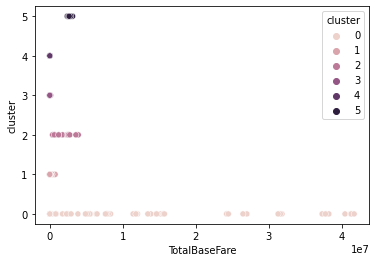

In [ ]:
sns.scatterplot(data = df_Route, x="TotalBaseFare", y="cluster", hue= df_Route.cluster)

<AxesSubplot:xlabel='BookTravelDays', ylabel='cluster'>

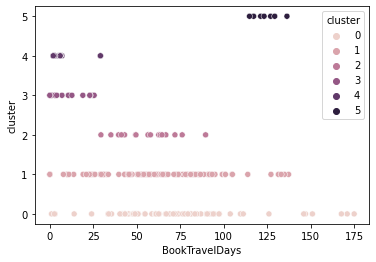

In [ ]:
sns.scatterplot(data = df_Route, x="BookTravelDays", y="cluster", hue= df_Route.cluster)

## Considering K-Means clusters for priority Route interpretations

### (Below Observed the Priority routes based on BookingCount, Flight Frequency, revenue generated)


In [ ]:
df_Route_km[df_Route_km.cluster == 0]['Route']

3      BOS-MSP
7      CUN-MSP
13     DCA-MSP
49     DFW-MSP
101    JFK-MSP
118    LAS-MSP
121    LAX-MSP
137    MCO-MSP
144    MSP-BOS
145    MSP-CUN
147    MSP-DCA
149    MSP-DFW
156    MSP-JFK
159    MSP-LAS
160    MSP-LAX
163    MSP-MCO
168    MSP-PHX
173    MSP-RSW
174    MSP-SAN
175    MSP-SEA
176    MSP-SFO
195    PHX-MSP
211    RSW-MSP
214    SAN-MSP
221    SEA-MSP
225    SFO-MSP
Name: Route, dtype: object